# Advanced Lane Finding

In [63]:
import os
import cv2
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# kill axis in rcParams
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
# enlarge default figure size
mpl.rc('figure', figsize=(10, 5))

Magic constants

In [57]:
# number of chessboard joints in each direction
NX = 9
NY = 6

# directory with camera calibration images
CAM_CAL_DIR = "camera_cal"

# directory for output images
OUT_DIR = "output_images"

# directory with test images
IN_DIR = "test_images"

## Calibrating camera

The following block performs camera calibration using OpenCV framework and an image directory, supplied with the task

camera_cal/calibration1.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
Just FYI the shape of calibration15.jpg is (721, 1281) does not match previous images shape (720, 1280)
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration4.jpg
camera_cal/calibration5.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
Just FYI the shape of calibration7.jpg is (721, 1281) does not match previous images shape (720, 1280)
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
Camera matrix: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Lens distortion coefficients: [[ -2.41017956

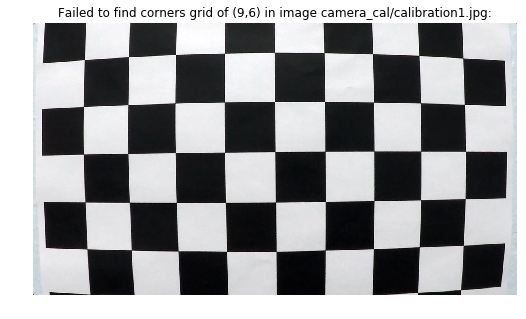

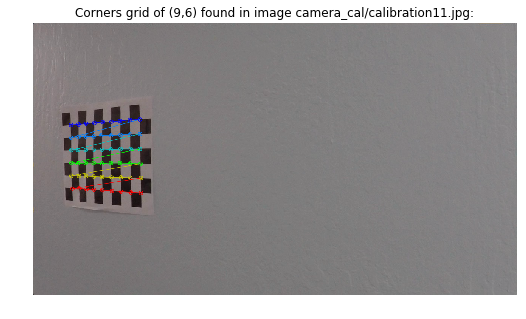

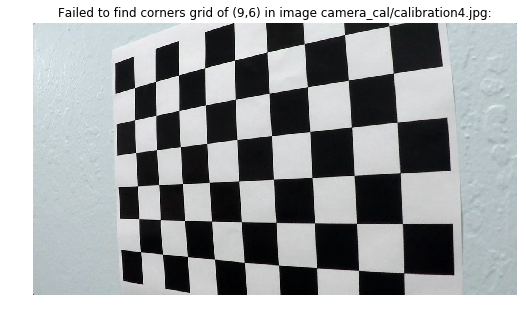

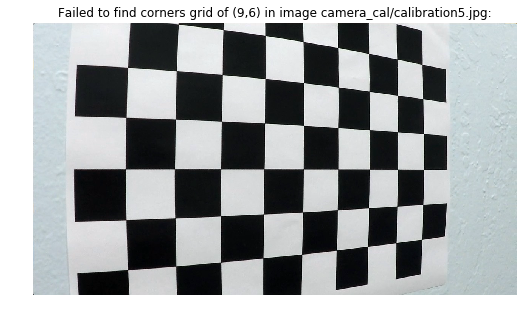

In [101]:
def extractCornersOne(path, bPlot=False):
    print(path)
    img = cv2.imread(path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)

    if not ret:
        corners = None
        fig = plt.figure()
        plt.title('Failed to find corners grid of ({},{}) in image {}:'.format(NX, NY, path))
        plt.imshow(img)
    elif bPlot:
        cv2.drawChessboardCorners(img, (NX, NY), corners, ret)
        fig = plt.figure()
        plt.title('Corners grid of ({},{}) found in image {}:'.format(NX, NY, path))
        plt.imshow(img)
        
    return corners, gray.shape

def extractCornersDir(path):
    corners = []
    i = 0
    shapeAll = None
    for img in os.listdir(path):
        cornersImg, shape = extractCornersOne(CAM_CAL_DIR + '/' + img, i == 1)
        if cornersImg is None:
            continue

        if shapeAll is None:
            shapeAll = shape
        elif shapeAll != shape:
            print('Just FYI the shape of {} is {} does not match previous images shape {}'.format(img, shape, shapeAll))
            
        corners.append(cornersImg)
        i += 1
    return corners, shapeAll

def calibrateCameraUsingImages(path):
    # create fixed representation of chessboard in the object space
    ptsObj = np.zeros((NX*NY, 3), np.float32)
    ptsObj[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1, 2)

    ptsImg, imgShape = extractCornersDir(path)
    
    #make sure there is a copy of object space for every image space feature sets
    ptsObj = [ptsObj] * len(ptsImg)
    
    #ptsObj = np.asarray(ptsObj)
    #print(ptsObj.shape)
    #print()

    #ptsImg = np.asarray(ptsImg)
    #print(ptsImg.shape)
    #print()

    ret, Mcam, dist, rvecs, tvecs = cv2.calibrateCamera(ptsObj, ptsImg, imgShape[::-1], None, None)
    return Mcam, dist

Mcam, dist = calibrateCameraUsingImages(CAM_CAL_DIR)
print('Camera matrix: {}'.format(Mcam))
print('Lens distortion coefficients: {}'.format(dist))

# Test Images Pipeline

## Image undistortion

Checking how the most warped image looks after undistortion:

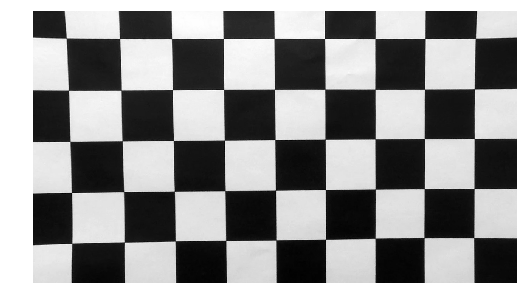

In [102]:
_img = cv2.imread(CAM_CAL_DIR + '/calibration1.jpg')
_img = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
_img = cv2.undistort(_img, Mcam, dist, None, Mcam)
cv2.imwrite(OUT_DIR + '/undistorted.jpg', _img)
plt.imshow(_img, cmap='gray')

Could be better, but we don't have more chessboard images from this camera, so nothing we can do about these imperfections - let's proceed

## Image binarization

## Perspective transform

In [160]:
def getRoadSrcPoints(imgSz):
    p_bl = (int(0.00 * imgSz[1]), int(0.93 * imgSz[0]))
    p_br = (int(1.00 * imgSz[1]), int(0.93 * imgSz[0]))
    p_tl = (int(0.435 * imgSz[1]), int(0.63 * imgSz[0]))
    p_tr = (int(0.565 * imgSz[1]), int(0.63 * imgSz[0]))
    return np.float32([p_tl, p_bl, p_br, p_tr])
    
def getRoadDstPoints(imgSz):
    return np.float32([(0,0), (0,imgSz[0]-1), (imgSz[1]-1,imgSz[0]-1), (imgSz[1]-1,0)])
    
def getRectifiedRoadTransform(imgSz):
    srcArr = getRoadSrcPoints(imgSz)
    dstArr = getRoadDstPoints(imgSz)
    Mwarp = cv2.getPerspectiveTransform(srcArr, dstArr)
    MwarpInv = cv2.getPerspectiveTransform(dstArr, srcArr)
    return Mwarp, MwarpInv

def getRectifiedRoad(img):
    Mwarp, _ = getRectifiedRoadTransform(img.shape)
    return cv2.warpPerspective(img, Mwarp, (img.shape[1], img.shape[0]))
    
def drawSrcRoadContour(img, srcArr):    
    srcArr = tuple(map(tuple, srcArr))
    cv2.line(img, srcArr[0], srcArr[1], (255,0,0), 5)
    cv2.line(img, srcArr[1], srcArr[2], (255,0,0), 5)
    cv2.line(img, srcArr[2], srcArr[3], (255,0,0), 5)
    cv2.line(img, srcArr[3], srcArr[0], (255,0,0), 5)
    
def visualizePerspectiveTransform():
    fname = IN_DIR + '/straight_lines1.jpg'
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    warped = getRectifiedRoad(img)
    drawSrcRoadContour(img, getRoadSrcPoints(img.shape))
    f, axarr = plt.subplots(1, 2, figsize=(15,15))
    axarr[0].imshow(img)
    axarr[1].imshow(warped)

Below is visualization of the perspective transform operation

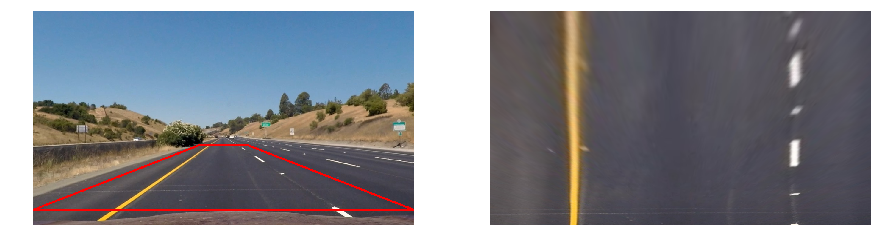

In [161]:
visualizePerspectiveTransform()

## All steps combined

In [163]:
def processOne(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    
    return img

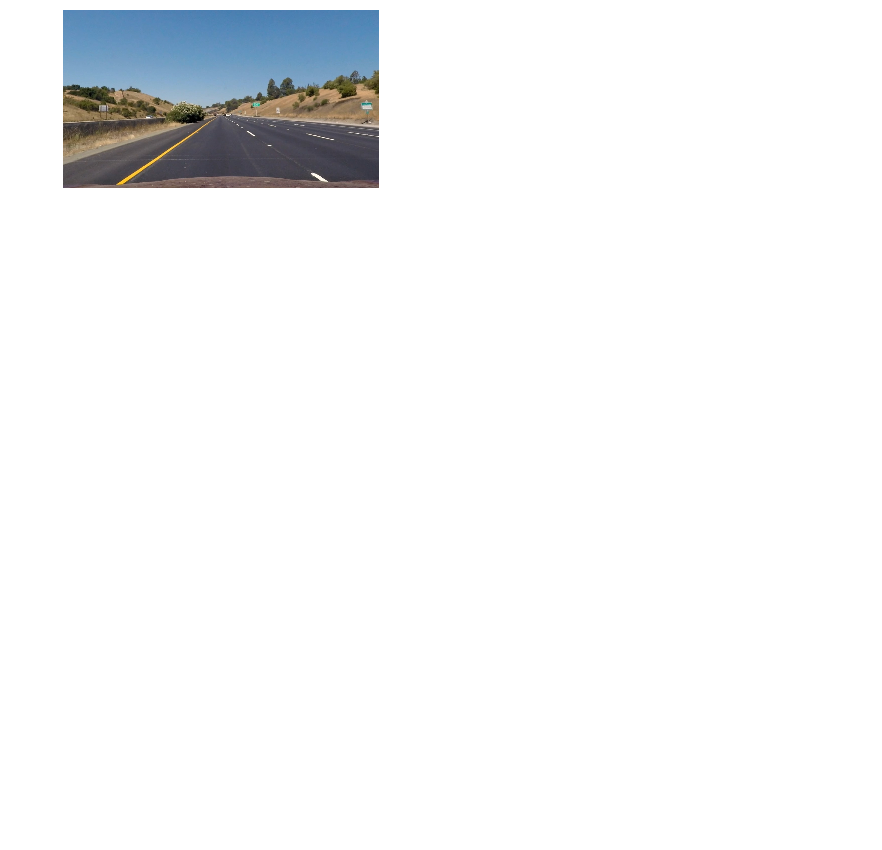

In [165]:
def testPipeline():
    listImages = os.listdir(IN_DIR)
    f, axarr = plt.subplots(len(listImages)//2, 2, figsize=(15,15))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = processOne(IN_DIR + '/' + fname)

        axarr[i].imshow(img, cmap=None if len(img.shape) == 3 else 'gray')


        i += 1
        break
    #f.tight_layout()
        
testPipeline()